In [1]:
# ! conda remove torchvision pytorch torchaudio -y

In [2]:
# ! conda install pytorch=2.0.1 torchvision=0.15.2 torchaudio pytorch::torchvision -c pytorch -y

In [3]:
import torch, torchvision
torchvision.disable_beta_transforms_warning()
import sys
import time
import os
import PIL
import pickle
import importlib
import numpy as np

In [4]:
def save(self, destination):
    from torch import package

    #internal modules
    MODULES = ['datasets', 'traininglib']
    
    if isinstance(destination, str):
        destination = time.strftime(destination)
        if not destination.endswith('.pt.zip'):
            destination += '.pt.zip'

    with package.PackageExporter(destination) as exp:
        interns = [__name__.split('.')[-1]]+MODULES
        exp.intern(interns)
        exp.extern('**', exclude=['torchvision.**'])
        externs = ['torchvision.ops.**', 'torchvision.datasets.**', 'torchvision.io.**']
        exp.intern('torchvision.**', exclude=externs)
        exp.extern(externs)
        exp.intern('torchvision.models.detection.**')
        # force inclusion of internal modules + re-save if importlib.reload'ed
        for m in MODULES:
            exp.save_module(m, dependencies=True)
        exp.save_module('modellib', dependencies=True)
        exp.save_pickle('model', 'model.pkl', self)
        exp.save_text('model', 'class_list.txt', '\n'.join(self.class_list))
    return destination

In [5]:
# training_label_dict = {4.0: 'MALL', 1.0: 'AMCO', 3.0: 'GWTE', 6.0: 'NSHO', 2.0: 'GADW', 8.0: 'RNDU', 5.0: 'NOPI', 7.0: 'REDH'}
from modellib import DuckDetector
model = DuckDetector(classes_of_interest=[ # class order must match the label_dict from training
                                    'AMCO', 'GADW', 'GWTE', 'MALL', 'NOPI', 'NSHO', 'REDH', 'RNDU'])

basemodel_pt_zip = save(self=model, destination="basemodel.pt.zip")

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
imp = torch.package.PackageImporter(basemodel_pt_zip)
print(imp.file_structure())

─── basemodel.pt.zip
    ├── .data
    │   ├── 0.storage
    │   ├── 1.storage
    │   ├── 10.storage
    │   ├── 11.storage
    │   ├── 12.storage
    │   ├── 13.storage
    │   ├── 14.storage
    │   ├── 15.storage
    │   ├── 16.storage
    │   ├── 17.storage
    │   ├── 18.storage
    │   ├── 19.storage
    │   ├── 2.storage
    │   ├── 20.storage
    │   ├── 21.storage
    │   ├── 22.storage
    │   ├── 23.storage
    │   ├── 24.storage
    │   ├── 25.storage
    │   ├── 26.storage
    │   ├── 27.storage
    │   ├── 28.storage
    │   ├── 29.storage
    │   ├── 3.storage
    │   ├── 30.storage
    │   ├── 31.storage
    │   ├── 32.storage
    │   ├── 33.storage
    │   ├── 34.storage
    │   ├── 35.storage
    │   ├── 36.storage
    │   ├── 37.storage
    │   ├── 38.storage
    │   ├── 39.storage
    │   ├── 4.storage
    │   ├── 40.storage
    │   ├── 41.storage
    │   ├── 42.storage
    │   ├── 43.storage
    │   ├── 44.storage
    │   ├── 45.storage
    │   ├── 46.storage
    

### <center>Test that packaged model opens</center>

In [8]:
def load_model(file_path:str, model_name:str) -> "torch.nn.Module":
            return torch.package.PackageImporter(file_path).load_pickle(model_name, f'{model_name}.pkl', map_location='cpu')

In [9]:
model = load_model(file_path='basemodel.pt.zip', model_name='model')


### <center> Process sample images </center>

In [10]:
model.class_list

['AMCO', 'GADW', 'GWTE', 'MALL', 'NOPI', 'NSHO', 'REDH', 'RNDU']

In [11]:
prediction = model.process_image('C:/Users/zack/Desktop/DuckNet_Data/Images_Test/DJI_20230105170403_0091_Z.JPG')

In [12]:
import matplotlib.pyplot as plt

# turn model.class_list into a dictionary
label_dict = {i+1: model.class_list[i] for i in range(len(model.class_list))}

# distinct colors 
distinct_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax


def plot_bbox_predicted(ax, boxes, labels, scores): # modify plot_bbox to add confidence scores
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    
    # add label and score to the bounding box. concatenate label and score to one string. 
    # use label_dict to replace class numbers with class names
    ax.text(boxes[:, 0], boxes[:, 1] - 100,
        s = f"{label_dict[labels.item()]} {scores.item():.2f}",
        color = 'black',
        fontsize = 6,
        verticalalignment = 'top',
        bbox = {'color': label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 'pad': 0})
    return ax


# function for plotting all predictions on images
def plot_predictions(image, boxes, labels, scores, ax = None):
    ax = img_show(image, ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox_predicted(ax, box, labels[i], scores[i])

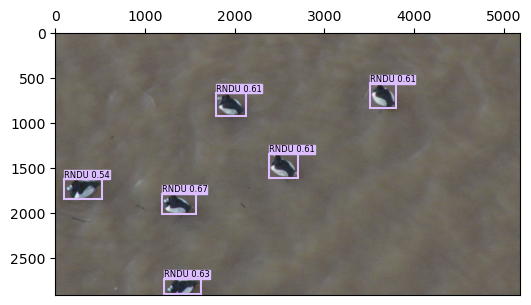

In [13]:
plot_predictions(model.load_image('C:/Users/zack/Desktop/DuckNet_Data/Images_Test/DJI_20230105170403_0091_Z.JPG'), 
                 prediction['boxes'][prediction['scores'] > 0.5], # scores > 0.5
                 prediction['labels'][prediction['scores'] > 0.5], 
                 prediction['scores'][prediction['scores'] > 0.5])

### <center>Train model</center> 

In [14]:
# # import datasets module
# from datasets import *
file_path = 'basemodel.pt.zip'
module = 'datasets'

datasets = torch.package.PackageImporter(file_path).import_module(module)

In [15]:
sample_dataset = datasets.DetectionDataset(jpgfiles = 'C:/Users/zack/Desktop/DuckNet_Data/Images_Test/',
                                    jsonfiles = 'C:/Users/zack/Desktop/DuckNet_Data/Annotations_Test/',
                                    augment = datasets.get_augments(train = True))    

In [16]:
image, target = sample_dataset[0]

In [17]:
print(target)

{'boxes': BoundingBox([[  0.0000, 168.6366,  72.3774, 214.8716],
             [197.8481, 211.2565, 300.0000, 264.5684]], format=BoundingBoxFormat.XYXY, spatial_size=(300, 300)), 'labels': tensor([0, 4]), 'image_id': tensor([0]), 'area': tensor([240693.0781, 306132.1875]), 'iscrowd': tensor([0, 0])}


In [18]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
distinct_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else None),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


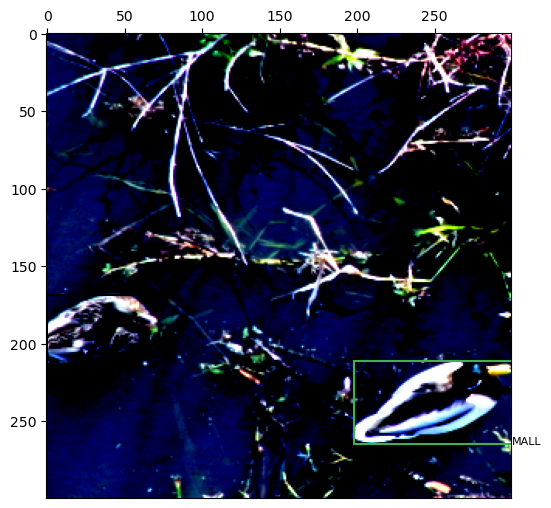

In [19]:
plot_detections(image, target['boxes'], target['labels'])

In [20]:
sample_dataloader = datasets.create_dataloader(sample_dataset, batch_size = 8, shuffle = True)

In [21]:
images, targets = next(iter(sample_dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


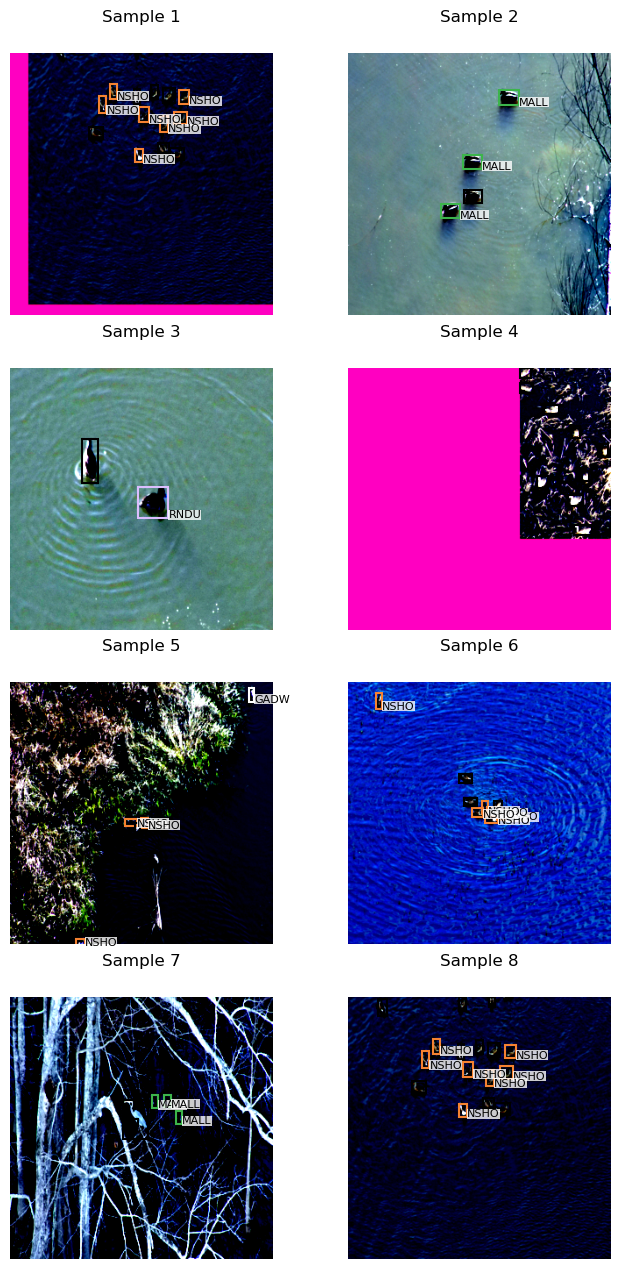

In [22]:
# Plot the all samples from batch in a grid of subplots. 
plt.figure(figsize = (8, 32))
for i in range(8):
    ax = plt.subplot(8, 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax = ax)
    plt.axis('off')
    plt.title(f"Sample {i + 1}")

plt.show()

In [23]:
model.start_training_detector(imagefiles_train='C:/Users/zack/Desktop/DuckNet_Data/Images_Train/',
                              jsonfiles_train = 'C:/Users/zack/Desktop/DuckNet_Data/Annotations_Train/')

Traceback (most recent call last):
  File "<torch_package_3>.traininglib.py", line 73, in fit
    self.train_one_epoch(loader_train, optim, sched)
  File "<torch_package_3>.traininglib.py", line 31, in train_one_epoch
    for i,batch in enumerate(loader):
  File "c:\Users\zack\anaconda3\envs\DuckNetApp\lib\site-packages\torch\utils\data\dataloader.py", line 633, in __next__
    data = self._next_data()
  File "c:\Users\zack\anaconda3\envs\DuckNetApp\lib\site-packages\torch\utils\data\dataloader.py", line 677, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "c:\Users\zack\anaconda3\envs\DuckNetApp\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\zack\anaconda3\envs\DuckNetApp\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<torch_package_2>

False